<a href="https://colab.research.google.com/github/ju-ki/atma10/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText
!rm -rf fastText

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.23 MiB | 31.90 MiB/s, done.
Resolving deltas: 100% (2416/2416), done.


In [3]:
pip install category_encoders xfeat

In [4]:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fasttext import load_model
sns.set()
CODE_PATH = "/content/drive/MyDrive/atmacup10/code/"
INPUT_PATH = "/content/drive/MyDrive/atmacup10/data/raw/"
OUTPT_PAHT = "/content/drive/MyDrive/atmacup10/data/submission/"

In [5]:
train = pd.read_csv(INPUT_PATH + "train.csv")
test = pd.read_csv(INPUT_PATH + "test.csv")

In [6]:
train.head(3)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5


In [7]:
def get_period_of_production(input_df):
  out_df = pd.DataFrame()
  out_df["period_of_production"] = input_df["dating_year_late"] - input_df["dating_year_early"]
  return out_df

In [8]:
model = load_model("/content/drive/MyDrive/atmacup10/data/external/lid.176.bin")

In [9]:
def get_label_lang(input_df, cols):
  out_df = pd.DataFrame()
  out_df["label_lang"] = input_df[cols].fillna("").map(lambda x: model.predict(x.replace("\n", ""))[0][0])
  return out_df.add_suffix(f"_{cols}")

In [10]:
train = pd.concat([train, get_label_lang(train, "title")], axis=1)
train = pd.concat([train, get_label_lang(train, "description")], axis=1)

test = pd.concat([test, get_label_lang(test, "title")], axis=1)
test = pd.concat([test, get_label_lang(test, "description")], axis=1)

In [11]:
def get_count(input_df, cols):
  out_df = pd.DataFrame()
  out_df["count"] = input_df[cols].apply(lambda x: len(x.split())).fillna(0)
  return out_df.add_suffix(f"_{cols}")

In [12]:
get_count(train, "title")

,count_title
0,4
1,3
2,4
3,4
4,4
...,...
12021,7
12022,10
12023,10
12024,6


In [13]:
train["acquisition_date"] = pd.to_datetime(train["acquisition_date"])

In [14]:
train["acquisition_date"].dt.year

0        1808.0
1        2000.0
2        2007.0
3        1881.0
4        1971.0
          ...  
12021    1994.0
12022    1881.0
12023    1887.0
12024    1881.0
12025    1941.0
Name: acquisition_date, Length: 12026, dtype: float64

In [15]:
def get_time_between_late_year_and_acqusition(input_df):
  input_df["acquisition_date"] = pd.to_datetime(input_df["acquisition_date"])
  input_df["year"] = input_df["acquisition_date"].dt.year.fillna(0)
  out_df = pd.DataFrame()
  out_df["period_of_acquisition_date"] = input_df["year"]- input_df["dating_year_late"].fillna(0).astype(float)
  return out_df

In [16]:
get_time_between_late_year_and_acqusition(train)

,period_of_acquisition_date
0,123.0
1,70.0
2,127.0
3,2.0
4,97.0
...,...
12021,74.0
12022,167.0
12023,109.0
12024,191.0


In [17]:
os.chdir("/content/drive/MyDrive/atmacup10/code/")
from feature_engine import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
class AbstractBaseBlock:
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
    
class WrapperBlock(AbstractBaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [19]:
from tqdm import tqdm

def get_function(block,is_train):
    s = mapping ={
        True:'fit',
        False:'transform'
    }.get(is_train)
    return getattr(block,s)

def to_feature(input_df,remain_df,blocks,is_train=False):
    out_df = remain_df
    
    for block in tqdm(blocks,total=len(blocks)):
        func = get_function(block,is_train)
        
        with timer(prefix='create' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df),func._name_
        out_df = pd.concat([out_df,_df],axis=1)
    return out_df

In [20]:
from time import time
from contextlib import contextmanager

@contextmanager
def timer(logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  out_str = format_str.format(d)
  if logger:
    logger.info(out_str)
  else:
    print(out_str)

In [21]:
class CountEncodingBlock(AbstractBaseBlock):
    
    """
    CountEncodingを行うブロック
    """
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, input_df, y=None):
        self.encoder = ce.CountEncoder()
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df = self.encoder.fit_transform(input_df[self.cols]).add_prefix("CE_")
        return out_df

In [22]:
CountEncodingBlock("label_lang_title").fit(get_label_lang(train, "title"))

,CE_label_lang_title
0,2342
1,9090
2,9090
3,2342
4,9090
...,...
12021,9090
12022,9090
12023,9090
12024,9090


In [23]:
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)

In [24]:
class AggregationBlock(AbstractBaseBlock):
    """
    集約変数を作成するブロック
    
    cols:
      group_key:元になる変数:age, country etc..
      group_values:集約を行う対象の変数:n_items etc..
      agg_methods:どのような方法で集約するか. デフォルトはmax, min, meanの三つ
    """
    def __init__(self, group_key, group_values, agg_methods=["max", "min", "mean"]):
        self.group_key = group_key
        self.group_values = group_values
        self.agg_methods = agg_methods
     
    def transform(self, input_df):
        self.agg_df, self.agg_col = xfeat.aggregation(input_df,
                                        agg_methods=self.agg_methods,
                                        group_key=self.group_key,
                                        group_values=self.group_values)
        
        out_df = pd.DataFrame()
        out_df = self.agg_df
        return out_df[self.agg_col]

In [25]:
AggregationBlock(group_key="label_lang_title", 
                                   group_values=["dating_period"],
                                   agg_methods=["max", "min", "std", "median", max_min, q75_q25]).transform(test)

,agg_max_dating_period_grpby_label_lang_title,agg_min_dating_period_grpby_label_lang_title,agg_std_dating_period_grpby_label_lang_title,agg_median_dating_period_grpby_label_lang_title,agg_<function max_min at 0x7f2ea424b5f0>_dating_period_grpby_label_lang_title,agg_<function q75_q25 at 0x7f2ea4309b00>_dating_period_grpby_label_lang_title
0,21,-2,1.313449,19.0,23,2.0
1,21,13,1.204547,17.0,8,2.0
2,21,-2,1.313449,19.0,23,2.0
3,21,-2,1.313449,19.0,23,2.0
4,21,-2,1.313449,19.0,23,2.0
...,...,...,...,...,...,...
12003,21,-2,1.313449,19.0,23,2.0
12004,21,-2,1.313449,19.0,23,2.0
12005,21,13,1.204547,17.0,8,2.0
12006,21,-2,1.313449,19.0,23,2.0


In [26]:
process_blocks = [
                 WrapperBlock(get_period_of_production),
                 WrapperBlock(get_time_between_late_year_and_acqusition),
                 CountEncodingBlock("label_lang_title"),
                 CountEncodingBlock("label_lang_description"),
                 CountEncodingBlock("acquisition_method"),
                 CountEncodingBlock("principal_maker"),
                 AggregationBlock(group_key="label_lang_title", 
                                   group_values=["dating_period"],
                                   agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="label_lang_description",
                                  group_values=["dating_period"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="acquisition_method",
                                  group_values=["dating_period"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
                 AggregationBlock(group_key="principal_maker",
                                  group_values=["dating_period"],
                                  agg_methods=["max", "min", "std", "median", max_min, q75_q25]),
]

In [33]:
drop_columns = ["object_id", "art_series_id", "description", "long_title", "title", "principal_maker", "principal_or_first_maker",
                  "sub_title", "copyright_holder", "more_title", "acquisition_credit_line", "dating_presenting_date",
                  "dating_sorting_date", "acquisition_date", "acquisition_method", "label_lang_title", "label_lang_description"]
train_feat_df = to_feature(train,train.drop(columns=drop_columns, axis=1),process_blocks, is_train=True)

test_feat_df = to_feature(test,test.drop(columns=drop_columns, axis=1),process_blocks,is_train=False)

  0%|          | 0/10 [00:00<?, ?it/s]

create<__main__.WrapperBlock object at 0x7f2ea413ca50> 0.003[s]
create<__main__.WrapperBlock object at 0x7f2ea413ce10> 0.023[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ce50> 0.009[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ce90> 0.008[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ced0> 0.008[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413cf10> 0.008[s]
create<__main__.AggregationBlock object at 0x7f2ea413cf50> 0.138[s]


 90%|█████████ | 9/10 [00:00<00:00, 12.83it/s]

create<__main__.AggregationBlock object at 0x7f2ea413cf90> 0.114[s]
create<__main__.AggregationBlock object at 0x7f2ea413cfd0> 0.115[s]


 20%|██        | 2/10 [00:00<00:00, 11.44it/s]

create<__main__.AggregationBlock object at 0x7f2ea412e050> 2.938[s]
create<__main__.WrapperBlock object at 0x7f2ea413ca50> 0.005[s]
create<__main__.WrapperBlock object at 0x7f2ea413ce10> 0.166[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ce50> 0.010[s]


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

 70%|███████   | 7/10 [00:00<00:00, 13.63it/s]

create<__main__.CountEncodingBlock object at 0x7f2ea413ce90> 0.014[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413ced0> 0.009[s]
create<__main__.CountEncodingBlock object at 0x7f2ea413cf10> 0.010[s]
create<__main__.AggregationBlock object at 0x7f2ea413cf50> 0.143[s]


 90%|█████████ | 9/10 [00:00<00:00, 10.54it/s]

create<__main__.AggregationBlock object at 0x7f2ea413cf90> 0.105[s]
create<__main__.AggregationBlock object at 0x7f2ea413cfd0> 0.110[s]


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

create<__main__.AggregationBlock object at 0x7f2ea412e050> 3.021[s]


In [37]:
print(train_feat_df.shape, test_feat_df.shape)

(12026, 34) (12008, 34)


In [36]:
train_feat_df = train_feat_df.drop(columns=["likes"], axis=1)

In [38]:
y = np.log1p(train["likes"])

In [39]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm
def fit_lgbm(X,
             y,
             cv, 
             params: dict=None,
             verbose: int=50):
    
    metric_func = mean_squared_error
    
    if params is None:
        params = {}
        
    models = []
    
    oof_pred = np.zeros_like(y ,dtype=np.float)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, x_valid = X[idx_train], X[idx_valid]
        y_train, y_valid = y[idx_train], y[idx_valid]
        
        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix="fit fold={}".format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
            
        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        
        print(f'K Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')
        
    score = metric_func(y, oof_pred) ** .5
    print('FINIHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [52]:
params = {
    "objective": "rmse",
    "max_depth": 7,
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "colsample_bytree": .5,
    "importance_type": "gain",
}

In [53]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y))

In [54]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.15928
[1000]	valid_0's rmse: 1.14676
[1500]	valid_0's rmse: 1.1418
[2000]	valid_0's rmse: 1.13854
[2500]	valid_0's rmse: 1.13662
[3000]	valid_0's rmse: 1.13673
Early stopping, best iteration is:
[2600]	valid_0's rmse: 1.13622
fit fold=15.565[s]
K Fold 0 RMSLE: 1.1362
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.16381
[1000]	valid_0's rmse: 1.14586
[1500]	valid_0's rmse: 1.13919
[2000]	valid_0's rmse: 1.13707
[2500]	valid_0's rmse: 1.13425
[3000]	valid_0's rmse: 1.13352
[3500]	valid_0's rmse: 1.13301
Early stopping, best iteration is:
[3237]	valid_0's rmse: 1.13265
fit fold=26.734[s]
K Fold 1 RMSLE: 1.1326
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 1.15097
[1000]	valid_0's rmse: 1.13842
[1500]	valid_0's rmse: 1.13049
[2000]	valid_0's rmse: 1.12778
[2500]	valid_0's rmse: 1.12591
[3000]	valid_0's rmse: 1.12477
[3500]	val

In [43]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    return fig, ax

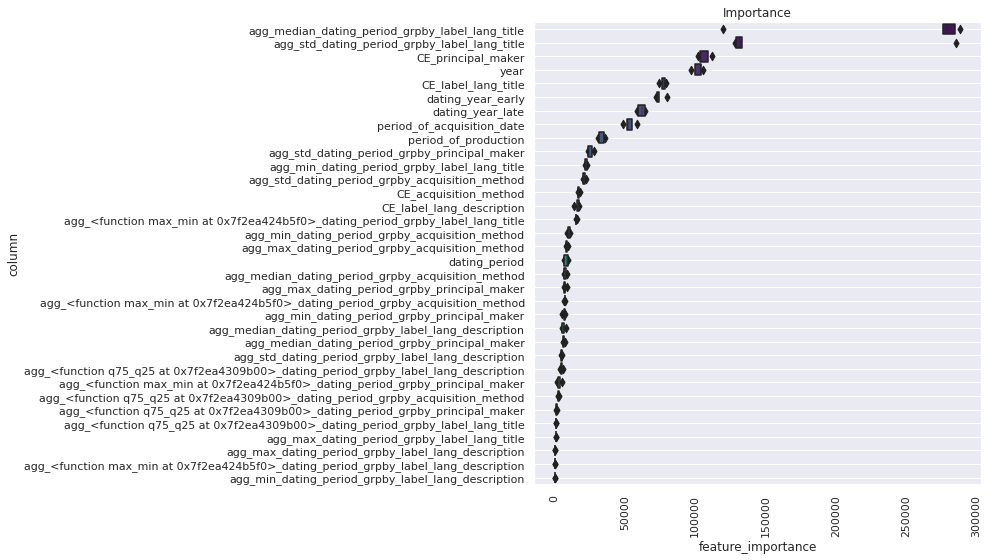

In [44]:
fig, _ = visualize_importance(models, feat_train_df=train_feat_df)

In [45]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [47]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPT_PAHT, 'baseline.csv'), index=False)

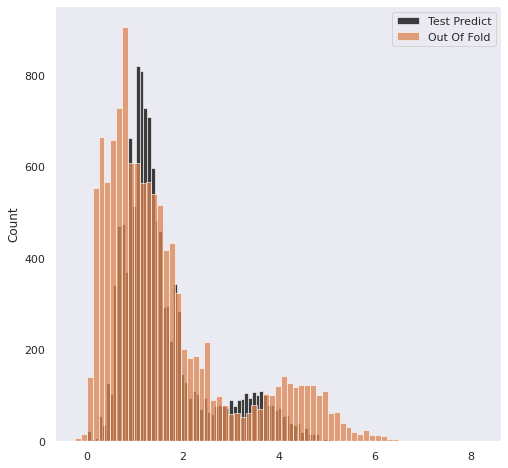

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

In [61]:
from sklearn.model_selection import GroupKFold
class GroupKFold:
    """
    GroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X=None, y=None, group=None):
        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = group.unique()
        for tr_group_idx, va_group_idx in kf.split(unique_ids):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(group.isin(tr_group))[0]
            val_idx = np.where(group.isin(va_group))[0]
            yield train_idx, val_idx


# PlaceID をキーにした Group K fold
def make_gkf(X, y, n_splits=5, random_state=2020):
    gkf = GroupKFold(n_splits=n_splits, random_state=random_state)
    return list(gkf.split(X, y, group))


# 評価関数(log(目的変数)を使っているためrmseを用いる)
def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** .5

In [62]:
def tree_importance(X, y, model, model_params, fit_params, cv, folds):
    est = model(**model_params)
    feature_importance_df = pd.DataFrame()
    for i, (tr_idx, va_idx) in enumerate(cv(X, y, n_splits=folds)):
        tr_x, va_x = X.values[tr_idx], X.values[va_idx]
        tr_y, va_y = y.values[tr_idx], y.values[va_idx]
        est.fit(tr_x, tr_y,
                eval_set=[[va_x, va_y]],
                **fit_params) 
        _df = pd.DataFrame()
        _df['feature_importance'] = est.feature_importances_
        _df['column'] = X.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                  palette='viridis')
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    plt.show()
    return fig, feature_importance_df

In [63]:
from lightgbm import LGBMModel
model = LGBMModel  # 使うモデル
group = train["art_series_id"]  # 今回は group kfold を用いる！


model_params = {  
    "n_estimators": 10000,
    "objective": 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 31,
    "random_state": 2021,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5
    }

# fit 時の parameter
fit_params = {
    "early_stopping_rounds": 100,
    "verbose": False
}

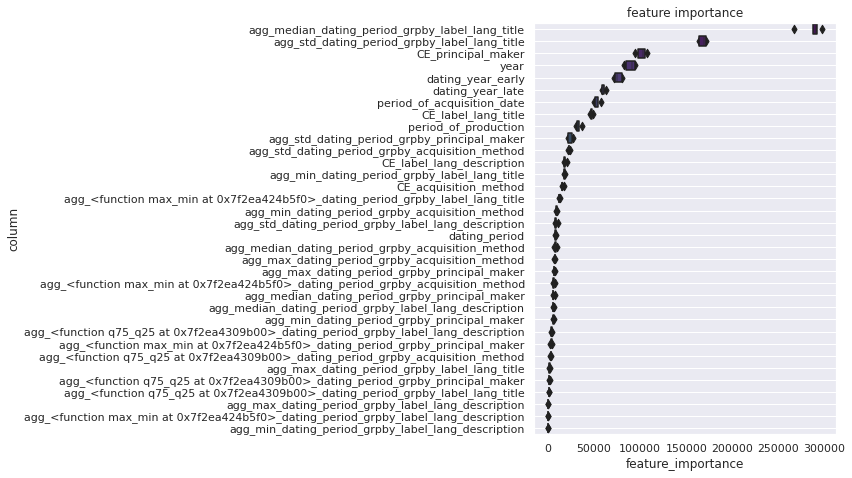

In [64]:
fig, _ = tree_importance(train_feat_df, y, model, model_params, fit_params, cv=make_gkf, folds=5)

In [65]:
from sklearn.metrics import mean_squared_error
def predict_cv(X, y, model, model_params, fit_params, cv, folds, seeds, metrics, name=""):
    oof_seeds = []; scores_seeds = []; models = {}
    for seed in seeds:
        oof = []; va_idxes = []; scores = []
        train_x, train_y = X.values, y.values
        fold_idx = cv(train_x, train_y, n_splits=folds, random_state=seed) 
        if "random_state" in model_params:
            model_params["random_state"] = seed
            
        # train and predict by cv folds
        for cv_num, (tr_idx, va_idx) in enumerate(fold_idx):
            tr_x, va_x = train_x[tr_idx], train_x[va_idx]
            tr_y, va_y = train_y[tr_idx], train_y[va_idx]
            va_idxes.append(va_idx)
            est = model(**model_params)

            # fitting - train
            est.fit(tr_x, tr_y,
                    eval_set=[[va_x, va_y]],
                    **fit_params) 
            model_name = f"{name}_SEED{seed}_FOLD{cv_num}_model"
            models[model_name] = est  # save model

            # predict - validation
            pred = est.predict(va_x)
            oof.append(pred)

            # validation score
            score = metrics(va_y, pred)
            scores.append(score)
            print(f"SEED:{seed}, FOLD:{cv_num} >>>> val_score:{score:.4f}")

        # sort as default
        va_idxes = np.concatenate(va_idxes)
        oof = np.concatenate(oof)
        order = np.argsort(va_idxes)
        oof = oof[order]
        oof_seeds.append(oof)
        scores_seeds.append(np.mean(scores))

    oof = np.mean(oof_seeds, axis=0)
    print(f"model:{name} score:{metrics(train_y, oof):.4f}\n")
    return oof, models
    
# oof予測値と学習済みモデルをGet!
oof, models = predict_cv(train_feat_df, y, model,  # 説明変数, 目的変数, モデル
                         model_params,  # モデルパラメータ 
                         fit_params,  # fit時のパラメータ
                         cv=make_gkf,  # cv strategy 
                         folds=5,   # num folds
                         seeds=[0, 1, 2], # 3 seed average
                         metrics=root_mean_squared_error,  # 評価関数
                         name="lgbm"
                        )		

SEED:0, FOLD:0 >>>> val_score:1.0693
SEED:0, FOLD:1 >>>> val_score:1.1504
SEED:0, FOLD:2 >>>> val_score:1.1579
SEED:0, FOLD:3 >>>> val_score:1.1287
SEED:0, FOLD:4 >>>> val_score:1.1560
SEED:1, FOLD:0 >>>> val_score:1.1336
SEED:1, FOLD:1 >>>> val_score:1.1312
SEED:1, FOLD:2 >>>> val_score:1.1452
SEED:1, FOLD:3 >>>> val_score:1.1346
SEED:1, FOLD:4 >>>> val_score:1.1276
SEED:2, FOLD:0 >>>> val_score:1.1535
SEED:2, FOLD:1 >>>> val_score:1.1181
SEED:2, FOLD:2 >>>> val_score:1.1303
SEED:2, FOLD:3 >>>> val_score:1.1229
SEED:2, FOLD:4 >>>> val_score:1.1576
model:lgbm score:1.1273



In [66]:
import random
from collections import defaultdict, Counter

def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1
        
    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    
    groups_per_fold = defaultdict(set)
    
    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        
        best_fold = None
        min_eval = None
        
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
                
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)
        
        
    all_groups = set(groups)
    
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]
        
        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]
        
        yield train_indices, test_indices

In [67]:
def create_bins(data, target, num):
  bins = pd.cut(
        np.log1p(data[target]),
        bins = num,
        labels = False
    )
  return bins

In [68]:
bins = create_bins(train, "likes", 10)
cv = list(stratified_group_k_fold(train, 
                                  bins,
                                  train["art_series_id"],
                                  10,
                                  seed=0))

In [69]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 1.47441
[100]	valid_0's rmse: 1.32506
[150]	valid_0's rmse: 1.25533
[200]	valid_0's rmse: 1.22253
[250]	valid_0's rmse: 1.20468
[300]	valid_0's rmse: 1.19434
[350]	valid_0's rmse: 1.18547
[400]	valid_0's rmse: 1.17891
[450]	valid_0's rmse: 1.1732
[500]	valid_0's rmse: 1.16929
[550]	valid_0's rmse: 1.16692
[600]	valid_0's rmse: 1.16494
[650]	valid_0's rmse: 1.16276
[700]	valid_0's rmse: 1.16098
[750]	valid_0's rmse: 1.15908
[800]	valid_0's rmse: 1.15667
[850]	valid_0's rmse: 1.15465
[900]	valid_0's rmse: 1.15314
[950]	valid_0's rmse: 1.15144
[1000]	valid_0's rmse: 1.15018
[1050]	valid_0's rmse: 1.1489
[1100]	valid_0's rmse: 1.148
[1150]	valid_0's rmse: 1.14665
[1200]	valid_0's rmse: 1.14596
[1250]	valid_0's rmse: 1.14547
[1300]	valid_0's rmse: 1.14444
[1350]	valid_0's rmse: 1.14354
[1400]	valid_0's rmse: 1.14311
[1450]	valid_0's rmse: 1.14278
[1500]	valid_0's rmse: 1.14249
[1550]	valid_0's rmse: 1.14231
[

In [70]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [71]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })

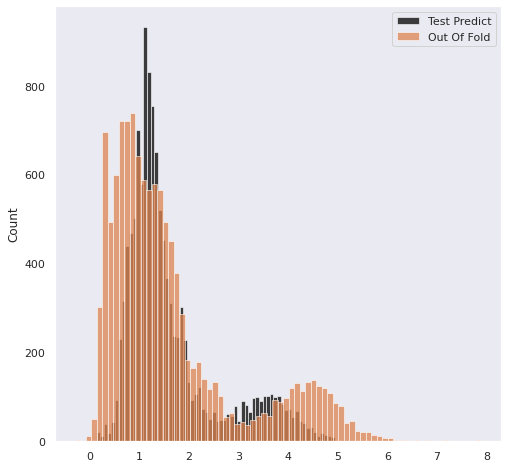

In [72]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()